In [1]:
# Importing libraries 
import pandas as pd
import matplotlib.pyplot as plt 


In [2]:
# Reading the data set 
df = pd.read_csv("C:/Users/ojohi/Downloads/cookie_cats.csv/cookie_cats.csv")

# show the first few rows
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


Exploration into the dataset to observe the differences between A/B group in terms of given variables.

In [3]:
# Number of unique player
df["userid"].nunique()

90189

In [4]:
# counting number of players in each A/B group 
df.groupby("version")[["userid"]].nunique()

,userid
version,
gate_30,44700
gate_40,45489


In [5]:
# exploring data 

df.pivot_table(index="version", values=['sum_gamerounds', 'retention_1', 'retention_7'], aggfunc='mean').reset_index()

,version,retention_1,retention_7,sum_gamerounds
0,gate_30,0.448188,0.190201,52.456264
1,gate_40,0.442283,0.182000,51.298776


In [6]:
# exploring data to find min and max values when both retention range is true 
true_retention7 = df[df['retention_7']]
min_value_sum_gamerounds = true_retention7['sum_gamerounds'].min()
true_retention1 = df[df['retention_1']]
max_value_sum_gamerounds = true_retention1['sum_gamerounds'].max()

print("The minimum value in sum_gamerounds where retention_7 is True is:", min_value_sum_gamerounds)
print("The maximum value in sum_gamerounds where retention_1 is True is:", max_value_sum_gamerounds)

The minimum value in sum_gamerounds where retention_7 is True is: 0
The maximum value in sum_gamerounds where retention_1 is True is: 2961


In [7]:
gate_30_group = df[df['version'] == 'gate_30'][['sum_gamerounds']].describe(percentiles=[.99]).T.reset_index()
gate_40_group = df[df['version'] == 'gate_40'][['sum_gamerounds']].describe(percentiles=[.99]).T.reset_index()

result = pd.concat([gate_30_group,gate_40_group ])
result.rename(columns={'index':'group'}, inplace=True)
result.reset_index(inplace=True)
result.drop('index', inplace=True, axis=1)
result.loc[0, 'group'] = 'gate_30'
result.loc[1, 'group'] = 'gate_40'

result

,group,count,mean,std,min,50%,99%,max
0,gate_30,44700.0,52.456264,256.716423,0.0,17.0,493.00,49854.0
1,gate_40,45489.0,51.298776,103.294416,0.0,16.0,492.12,2640.0


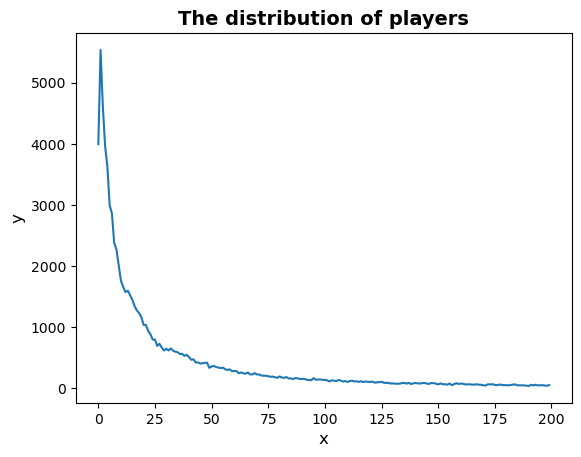

In [8]:
# The distribution of game rounds 

# counting the number of players fpr each number of gamerounds 
plot_df = df.groupby("sum_gamerounds")["userid"].count()


# plotting the distribution of players that played 0 to 100 game rounds 
ax = plot_df.head(200).plot()
plt.title("The distribution of players", fontweight = "bold", size = 14)
plt.xlabel("x", size = 12)
plt.ylabel("y", size = 12)
plt.show()

In [9]:
df[df["sum_gamerounds"]== 0]["userid"].count()

3994

In [10]:
df_retention = df[["retention_1","retention_7"]].mean()*100
print(f"1-day retention: {round(df_retention[0],2)}% \
        \n7-days retention ratio: {round(df_retention[1],2)}%")

1-day retention: 44.52%         
7-days retention ratio: 18.61%


In [11]:
retention_counts = df["retention_1"].value_counts()

# Extract counts
true_count = retention_counts.get(True, 0)
false_count = retention_counts.get(False, 0)

# Print the counts
print(f"Number of True values: {true_count}")
print(f"Number of False values: {false_count}")

Number of True values: 40153
Number of False values: 50036


In [12]:
# calculating 1-day and 7-day retention for each A/B group

df_retention_ab = df.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean", "sum_gamerounds":"sum"})
df_retention_ab

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,2344795
gate_40,45489,0.442283,0.182000,2333530


A/B Testing: Bootstrapping.

The steps being taken are as follows: 
 - Creating 500 samples of dataset (bootstraping)
 - Calculating 1-day & 7-days retentions for A/B groups
 - Plotting the bootstrap distributions
 - Calculating retention rate difference between the two A/B groups
 - Calculating the probability that 1-day & 7-days retentions are greater when the gate is at level 30
 - Evaluating results and making recommendation

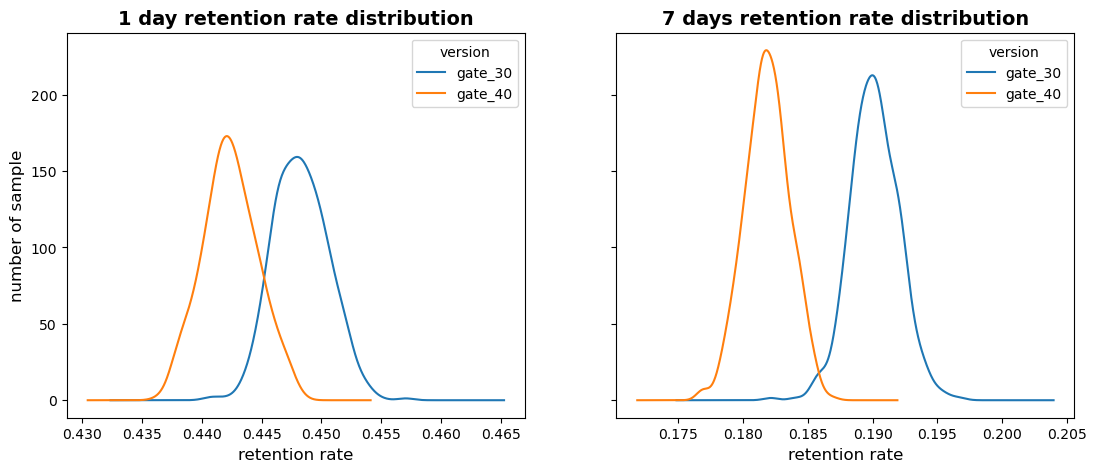

In [13]:
# Creating an list with bootstrapped means for each A/B group

boot_1d = []
boot_7d = []

for i in range(500):
    boot_mean_1 = df.sample(frac=1, replace = True).groupby('version')['retention_1'].mean()
    boot_mean_7 = df.sample(frac=1, replace = True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean_1)
    boot_7d.append(boot_mean_7)
    
# Transforming the list to a dataframe
boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)

# Kernel Density Estimate plot of the bootstrao distributions 
fig, (ax1,ax2) = plt.subplots(1,2, sharey = True, figsize = (13,5))

boot_1d.plot.kde(ax=ax1)
ax1.set_xlabel("retention rate", size=12)
ax1.set_ylabel("number of sample", size=12)
ax1.set_title("1 day retention rate distribution", fontweight = "bold", size = 14)

boot_7d.plot.kde(ax=ax2)
ax2.set_xlabel("retention rate",size=12)
ax2.set_title("7 days retention rate distribution", fontweight="bold",size=14)
plt.show()

These two distributions above represent the bootstrap uncertainty over what the underlying 1-day & 7-days retention could be for the two A/B groups. Just eyeballing this plot, we can see that there seems to be some evidence of a difference, although small.

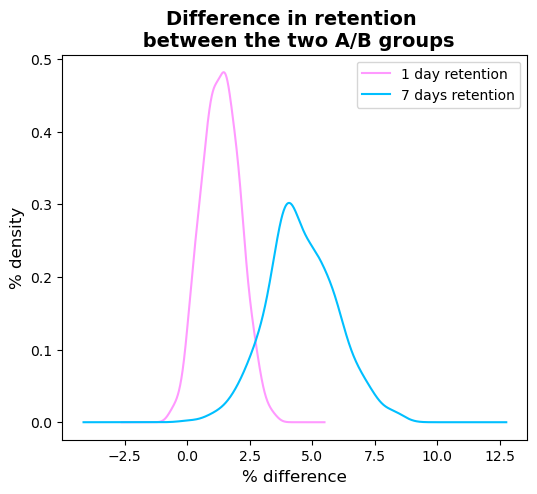

In [14]:
# Adding a column with the % difference between the two A/B groups
boot_1d['diff'] = ((boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] * 100)
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100)

# Ploting the bootstrap % difference
fig, (ax1) = plt.subplots(1, 1,figsize=(6,5))

boot_1d['diff'].plot.kde(ax=ax1, c="#ff99ff", label = "1 day retention")
boot_7d['diff'].plot.kde(ax=ax1, c= "#00bfff", label = "7 days retention")
ax1.set_xlabel("% difference",size=12)
ax1.set_ylabel("% density",size=12)
ax1.set_title("Difference in retention \n between the two A/B groups", fontweight="bold", size=14)
plt.legend()
plt.show()


From these chart, we can see that the most likely % difference is around 1% - 2% for 1-day retention. For 7-days retention the most likely % difference is around 2% - 5%. Moreover, the most of the distribution is above 0%, in favor of a gate at level 30.

In [15]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30

prob_1 = (boot_1d['diff']>0).sum()/len(boot_1d['diff'])

# Calculating the probaility that 7-day retention is greater when the gate is at level 30 

prob_7 = (boot_7d['diff']>0).sum()/len(boot_7d['diff'])

# Pretty printing the probability
print(f"The probability that 1-day retention is greater when the gate is at level 30: {round(prob_1,2)*100}% \
      \nThe probability that 7-days retention is greater when the gate is at level 30: {(prob_7)*100}% ")


The probability that 1-day retention is greater when the gate is at level 30: 97.0%       
The probability that 7-days retention is greater when the gate is at level 30: 100.0% 


In conclusion

The bootstrap result gives strong evidence of a 99.8% probability that 7-day retention is higher when the gate is at level 30 than when it is at level 40. The conclusion is: If we want to keep retention high — both 1-day and 7-day retention — we should not move the gate from level 30 to level 40. There are, of course, other metrics we could look at, like the number of game rounds played or how much in-game purchases are made by the two AB-groups. But retention is one of the most important metrics.